In [114]:
import scipy.io as sio 
import numpy as np
import pandas as pd
from scipy import stats
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.optimizers import adam, SGD, Adagrad, RMSprop
dat = sio.loadmat('satimage-2.mat')
df = pd.DataFrame(np.hstack((dat['X'], dat['y'])))

In [106]:
df.groupby(36).count()[0]
# df.shape
#df.isnull().values.any()

36
0.0    5732
1.0      71
Name: 0, dtype: int64

In [107]:
df = df.rename(columns={36: 'result'})

In [108]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
X_train = X_train[X_train.result == 0].drop(['result'], axis=1)
y_test = X_test['result']
X_test = X_test.drop(['result'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [109]:
X_test

array([[ 67.,  84.,  97., ...,  98., 106.,  91.],
       [ 57.,  56.,  82., ...,  57.,  79.,  70.],
       [ 97., 115., 124., ...,  87.,  96.,  74.],
       ...,
       [ 74.,  88.,  97., ...,  87.,  87.,  70.],
       [ 56.,  53.,  73., ...,  53.,  74.,  69.],
       [ 60.,  94., 102., ...,  87., 104.,  87.]])

In [115]:
input_dim = X_train.shape[1]
encoding_dim = 17
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [122]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer= Adagrad(lr=0.05), 
                    loss='mean_squared_error', 
                    metrics=['accuracy'],
                   )
# checkpointer = ModelCheckpoint(filepath="model.h5",
#                                verbose=0,
#                                save_best_only=True)
# tensorboard = TensorBoard(log_dir='./logs',
#                           histogram_freq=0,
#                           write_graph=True,
#                           write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test)).history

Train on 4585 samples, validate on 1161 samples
Epoch 1/100
4585/4585 [==============================] - 1s 269us/step - loss: 4399.4123 - acc: 0.1080 - val_loss: 4180.1929 - val_acc: 0.1283
Epoch 2/100
4585/4585 [==============================] - 0s 73us/step - loss: 4129.5545 - acc: 0.1080 - val_loss: 4000.2087 - val_acc: 0.1283
Epoch 3/100
4585/4585 [==============================] - 0s 67us/step - loss: 3981.5114 - acc: 0.1080 - val_loss: 3879.1475 - val_acc: 0.1283
Epoch 4/100
4585/4585 [==============================] - 0s 72us/step - loss: 3875.5231 - acc: 0.1080 - val_loss: 3788.1744 - val_acc: 0.1283
Epoch 5/100
4585/4585 [==============================] - 0s 67us/step - loss: 3793.4918 - acc: 0.1080 - val_loss: 3715.7225 - val_acc: 0.1283
Epoch 6/100
4585/4585 [==============================] - 0s 74us/step - loss: 3727.0039 - acc: 0.1080 - val_loss: 3656.1765 - val_acc: 0.1283
Epoch 7/100
4585/4585 [==============================] - 0s 65us/step - loss: 3671.6872 - acc: 0.10

Epoch 58/100
4585/4585 [==============================] - 0s 59us/step - loss: 3218.3695 - acc: 0.1080 - val_loss: 3187.6316 - val_acc: 0.1283
Epoch 59/100
4585/4585 [==============================] - 0s 57us/step - loss: 3217.6546 - acc: 0.1080 - val_loss: 3187.0037 - val_acc: 0.1283
Epoch 60/100
4585/4585 [==============================] - 0s 58us/step - loss: 3216.9857 - acc: 0.1080 - val_loss: 3186.4112 - val_acc: 0.1283
Epoch 61/100
4585/4585 [==============================] - 0s 58us/step - loss: 3216.3526 - acc: 0.1080 - val_loss: 3185.8608 - val_acc: 0.1283
Epoch 62/100
4585/4585 [==============================] - 0s 59us/step - loss: 3215.7632 - acc: 0.1080 - val_loss: 3185.3450 - val_acc: 0.1283
Epoch 63/100
4585/4585 [==============================] - 0s 58us/step - loss: 3215.2083 - acc: 0.1080 - val_loss: 3184.8596 - val_acc: 0.1283
Epoch 64/100
4585/4585 [==============================] - 0s 57us/step - loss: 3214.6850 - acc: 0.1080 - val_loss: 3184.4100 - val_acc: 0.1283

<function matplotlib.pyplot.show(*args, **kw)>

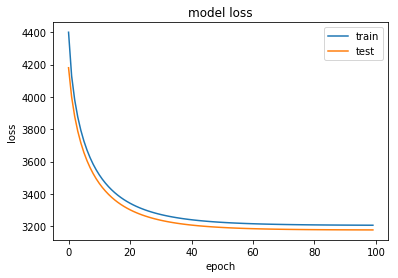

In [123]:
import matplotlib.pyplot as plt
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show

In [125]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,1161.000000,1161.000000
mean,3178.244396,0.012059
std,941.747156,0.109194
min,1645.055233,0.000000
25%,2342.561836,0.000000
50%,2998.825775,0.000000
75%,4035.790478,0.000000
max,5970.734889,1.000000


In [85]:
# X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
# X_train = X_train[X_train.result == 0].drop(['result'], axis=1)
# y_test = X_test['result']
# X_test = X_test.drop(['result'], axis=1)
# X_test

In [128]:
np.mean(X_test,axis = 0)

array([71.8794143 , 88.0585702 , 97.39707149, 78.61584841, 71.54177433,
       87.45047373, 96.88458226, 78.28596038, 71.08268734, 86.72523686,
       96.55469423, 78.21533161, 71.94315245, 88.27734711, 97.53229974,
       78.51593454, 71.59776055, 87.67355728, 96.84065461, 78.08440999,
       71.07149009, 86.99138674, 96.50129199, 77.80964686, 71.52713178,
       87.88372093, 97.41429802, 78.67183463, 71.13178295, 87.42204996,
       96.89319552, 78.23944875, 70.7588286 , 86.6709733 , 96.48320413,
       78.12661499])

In [127]:
predictions

array([[71.68732, 87.84759, 95.2983 , ...,  0.     , 95.14016, 78.40045],
       [71.68732, 87.84759, 95.2983 , ...,  0.     , 95.14016, 78.40045],
       [71.68732, 87.84759, 95.2983 , ...,  0.     , 95.14016, 78.40045],
       ...,
       [71.68732, 87.84759, 95.2983 , ...,  0.     , 95.14016, 78.40045],
       [71.68732, 87.84759, 95.2983 , ...,  0.     , 95.14016, 78.40045],
       [71.68732, 87.84759, 95.2983 , ...,  0.     , 95.14015, 78.40045]],
      dtype=float32)